### Performing checks for the resources available

In [145]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Installing huggingface transformers library

In [146]:
!pip install transformers

## Importing necessary packages

In [147]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import time
import datetime
from sklearn.metrics import classification_report,confusion_matrix
import random
import time
import torch.nn as nn
from transformers import AutoModel , AutoModelForSequenceClassification, AutoConfig , AutoTokenizer , AdamW ,get_linear_schedule_with_warmup
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

## Setting some configuration values

In [148]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,12)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Importing drive into the colaboratory

In [149]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading training data

In [150]:

train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ariful/train_data (3).csv')

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))

# Display 10 random rows from the data.
train_df.sample(10)

Number of training sentences: 6,602



,PID,text,labels
4256,1450,একটি দৃশ্য সঙ্গে খাদ্য। একটি কোণ ঘুরাঘুরি এর জ...,positive
3167,461,"গ্রেট খাদ্য, বিশেষভাবে JadurKathi.com দেশী(Lol...",positive
5424,6036,আমি তাদের মেগা প্লেটার যা ভ্যাট এবং সার্ভিস চা...,negative
4019,9907,একটি উচ্চ প্রাইস.Nothing সঙ্গে খুব খারাপ সেবা ...,negative
683,5901,নিম্ন মানের খাদ্য। BBQ মুরগির খারাপ গন্ধ .. ইয়...,negative
2899,3076,onkkk mojar kabar Gulo & ফোঁপানোর kceu onkkkk ...,positive
2464,2913,এই রেস্তোরাঁর আমন্ত্রিত সব বন্ধু ভাই ও বোনেরা ...,positive
5436,6151,তুমি তোমার খাদ্য উন্নতি প্রয়োজন। চিকেন পিজা স...,negative
3787,10421,গড় খাবারের গুণমান তবে তাদের পরিষেবার মানটি এত...,neutral
1195,4587,এই রেস্তোরায় কফি টানা বেশ কয়েক ঘন্টা কাজ করা...,positive


In [151]:
train_df

,PID,text,labels
0,3143,আমি সব খাদ্য শহুরে চামচ পছন্দ,positive
1,5010,আমি সত্যিই বিশ্বাস না হয় যে বিস্ফোরক ডায়রিয়...,positive
2,3206,আমার প্রিয় এক স্থান এটা। সেবা ভাল & চমৎকার স্...,positive
3,9985,"খাবার ভাল ছিল, কিন্তু সেহরি সময় সেবা খারাপ। আ...",negative
4,10539,অসাধারণ ভাল খাবার ... পরিবেশ: 10/10 আচরণ: 9/10...,neutral
...,...,...,...
6597,5735,জট্টিল স্বাদ। খুব ভালো কর্মচারী বন্ধুত্বপূর্ণ ...,negative
6598,5192,চিফ কাসিনে এর সাথে তুলনা করলে বুর্গের এর সাইজও...,positive
6599,5391,জ্যামাইকান ফ্রাই প্লেটার সত্যিই ভাল।,positive
6600,861,শ্রেষ্ঠ JadurKathi.com বাংলাদেশের ধান ও বাংলাদ...,positive


In [152]:
train_df['labels'].value_counts()

positive    3345
negative    2647
neutral      610
Name: labels, dtype: int64

In [153]:

le = LabelEncoder()
train_df['labels'] = le.fit_transform(train_df['labels'])

In [154]:
train_df['labels'].value_counts()

2    3345
0    2647
1     610
Name: labels, dtype: int64

### Loading `train_sentences` and `train_labels`

In [155]:
# Get the lists of sentences and their labels.
train_sentences = train_df['text'].values
train_labels = train_df['labels'].values

## Saving Class Names

In [156]:
class_names = [
               'positive','negative','neutral'
]

## Loading the validation data

In [157]:
# val_df_path = join(dataset_dir,'tamil_offensive_full_dev_corrected.csv')
# Load the dataset into a pandas dataframe.
val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ariful/valid_data.csv')

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(val_df.shape[0]))

# Display 10 random rows from the data.
val_df.sample(10)

Number of training sentences: 2,201



,PID,text,labels
1245,6342,Cheeseroom বার্গার একেবারেই ফালতু ছিল ফ্রেন্স ...,negative
22,9628,সার্ভিস আপ চিহ্ন খাদ্য মূল্য তুলনা ছিল না ....,negative
563,5381,জ্যামাইকান চিকেন আমি সেখানে সময় এবং সময় :) #...,positive
1628,9998,এফএনএফ সঙ্গে ছোট করুন একসাথে জন্য খুব ভাল জায়...,negative
1239,5428,আমি দেখেছি খাবারেএ মান গত 2 পরিদর্শনে কমে গেছে।,negative
1034,4044,খাদ্য সুন্দর ছিল !!!,positive
305,9610,ফটো তোলার জন্য চমৎকার জায়গা। ই.এম. অনেক। কিন্...,negative
917,10404,আমি মিঃ হপার চেষ্টা করেছি। এটা ভাল ছিল। তবে পর...,neutral
705,3884,এটি একটি ভয়ঙ্কর জায়গা সময় কাটাতে এবং এটি সে...,positive
1199,7738,এখানে যাবেন না। খারাপ রেস্টুরেন্টে অভিজ্ঞতা আম...,negative


In [158]:
val_df['labels'].value_counts()

positive    1124
negative     896
neutral      181
Name: labels, dtype: int64

In [159]:
val_df['labels'] = le.transform(val_df['labels'])

In [160]:

val_df['labels'].value_counts()

2    1124
0     896
1     181
Name: labels, dtype: int64

### Loading `val_sentences` and `val_labels`

In [161]:
# Get the lists of sentences and their labels.
val_sentences = val_df['text'].values
val_labels = val_df['labels'].values

## Helper Functions

#### 1) Update Interval Function

In [162]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller.
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

#### 2) Format time function

In [163]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


#### 3) Make Smart Batches function

In [164]:
def make_smart_batches(text_samples, labels, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(labels)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(labels), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_labels = []

    # For each batch...
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_labels)


In [165]:
def make_smart_batches_on_test(text_samples, text_ids, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(text_samples)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(text_samples), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, text_ids), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_ids = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_ids.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_ids = []

    # For each batch...
    for (batch_inputs, batch_ids) in zip(batch_ordered_sentences, batch_ordered_ids):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_ids.append(torch.tensor(batch_ids))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_ids)


#### 4) Function for calculating accuracy per class

In [166]:
def accuracy_per_class(preds, labels , label_dict):

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict[label]}')
        print(f'Accuracy: {round(100*len(y_preds[y_preds==label])/len(y_true) , 2)}\n')

### 5) Function for plotting training history

In [167]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

### 6) Function to check accuracy

In [168]:
def check_accuracy(predictions,true_labels):
  # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  # Calculate simple flat accuracy -- number correct over total number.
  accuracy = (preds == true_labels).mean()

  return accuracy

### 7) Function to evaluate model

In [169]:
def eval_model(model,py_inputs, py_attn_masks, py_labels):
# Prediction on test set
  t0 = time.time()

  print('Doing validation on {:,} sentences...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()
  total_val_loss = 0

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)


      logits = output.logits
      loss = output.loss
      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)

      total_val_loss += loss.item()

  val_accuracy = check_accuracy(predictions,true_labels)

  validation_time = format_time(time.time() - t0)

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_val_loss / len(py_inputs)


  # print('Accuracy: {:.3f}'.format(val_accuracy))
  return (avg_val_loss,val_accuracy,validation_time)


### 8) Function for making predictions on our test dataset

In [170]:
def get_predictions(py_inputs, py_attn_masks, py_labels):

  print('Predicting labels for {:,} test batches...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

      # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return (preds,true_labels)

### 9) Function for making predictions on test dataset(without labels)

In [171]:
def get_predictions_test(py_inputs, py_attn_masks,py_ids):

  print('Predicting labels for {:,} test batches...'.format(len(py_inputs)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels ,ids = [], [] , []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_ids = py_ids[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      b_ids = b_ids.detach().cpu().numpy()
      # Store predictions
      predictions.append(logits)
      ids.append(b_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  ids = np.concatenate(ids,axis=0)
  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return ids,preds

### 10) Confusion Matrix Helper Function

In [172]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Value')
  plt.xlabel('Predicted Value');

## Smart Batching of the training data

In [173]:

#model_name='sagorsarker/bangla-bert-base'
#model_name='csebuetnlp/banglabert'
#model_name='xlm-roberta-base'
#model_name='neuralspace-reverie/indic-transformers-bn-distilbert'
model_name='bert-base-multilingual-cased'
# Load the BERT tokenizer.
print(f'Loading {model_name} tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

Loading bert-base-multilingual-cased tokenizer...


In [174]:
lengths = []
for text in train_sentences:
  lengths.append(len(text))

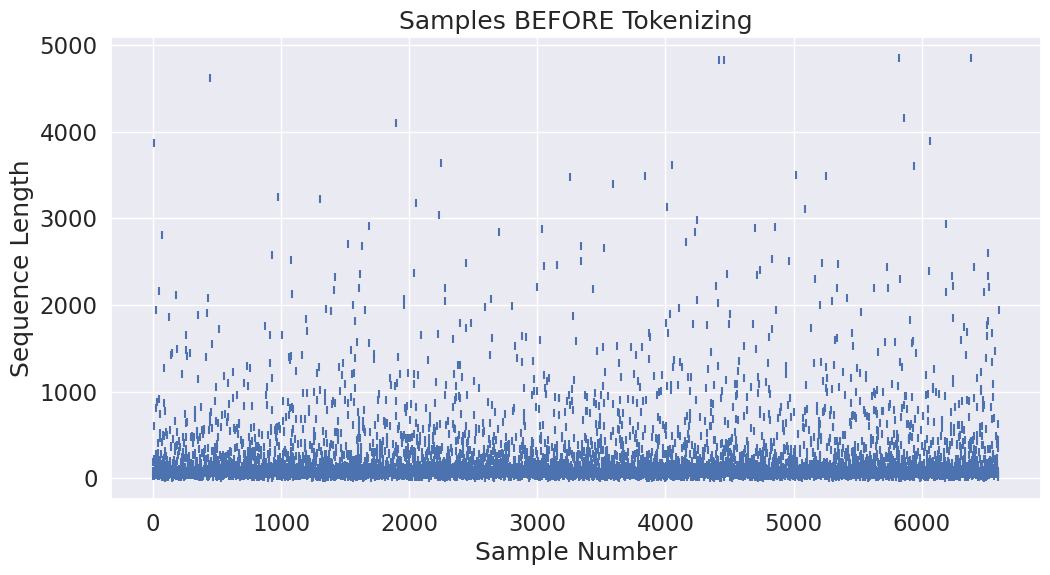

In [175]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(lengths)), lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Tokenizing')

plt.show()

### Tokenizing the sequences

In [176]:
max_input_length = 400

In [177]:
full_input_ids = []
labels = []

# Tokenize all training examples
print('Tokenizing {:,} training samples...'.format(len(train_sentences)))

# Choose an interval on which to print progress updates.
update_interval = good_update_interval(total_iters=len(train_sentences), num_desired_updates=10)

# For each training example...
for text in train_sentences:

    # Report progress.
    if ((len(full_input_ids) % update_interval) == 0):
        print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

    # Tokenize the sentence.
    input_ids = tokenizer.encode(text=text,
                                 add_special_tokens=True,
                                 max_length=max_input_length,
                                 truncation=True,
                                 padding=False)

    # Add the tokenized result to our list.
    full_input_ids.append(input_ids)

print('DONE.')
print('{:>10,} samples'.format(len(full_input_ids)))

Tokenizing 6,602 training samples...
  Tokenized 0 samples.
  Tokenized 700 samples.
  Tokenized 1,400 samples.
  Tokenized 2,100 samples.
  Tokenized 2,800 samples.
  Tokenized 3,500 samples.
  Tokenized 4,200 samples.
  Tokenized 4,900 samples.
  Tokenized 5,600 samples.
  Tokenized 6,300 samples.
DONE.
     6,602 samples


In [178]:
# Get all of the lengths.
unsorted_lengths = [len(x) for x in full_input_ids]

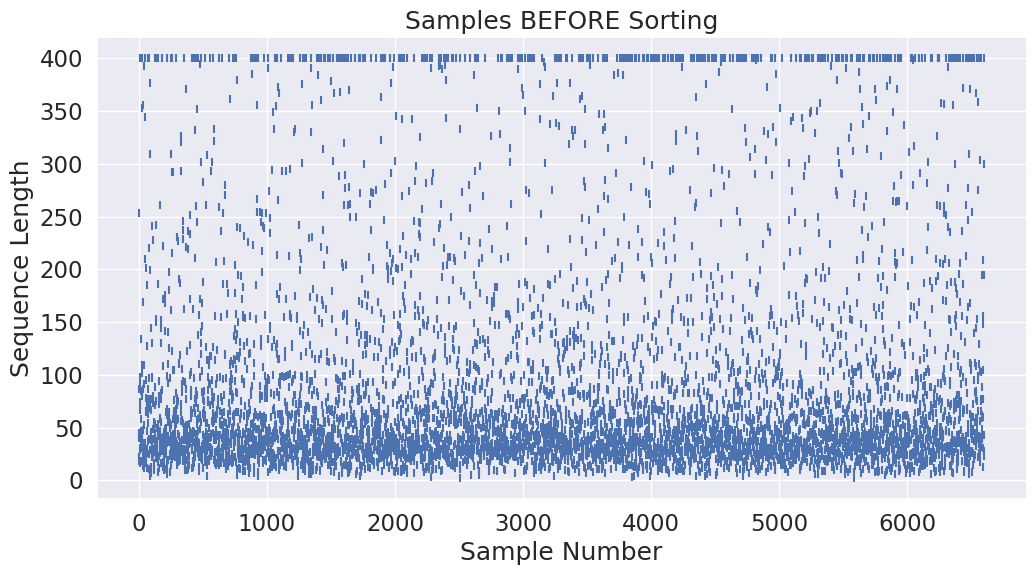

In [179]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.show()

In [180]:
# Sort the two lists together by the length of the input sequence.
train_samples = sorted(zip(full_input_ids, train_labels), key=lambda x: len(x[0]))

In [181]:
train_samples[0:5]

[([101, 102], 1),
 ([101, 102], 1),
 ([101, 51386, 102], 1),
 ([101, 106446, 102], 2),
 ([101, 946, 18243, 102], 1)]

In [182]:
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 2
Longest sample: 400


In [183]:
# Get the new list of lengths after sorting.
sorted_lengths = [len(s[0]) for s in train_samples]

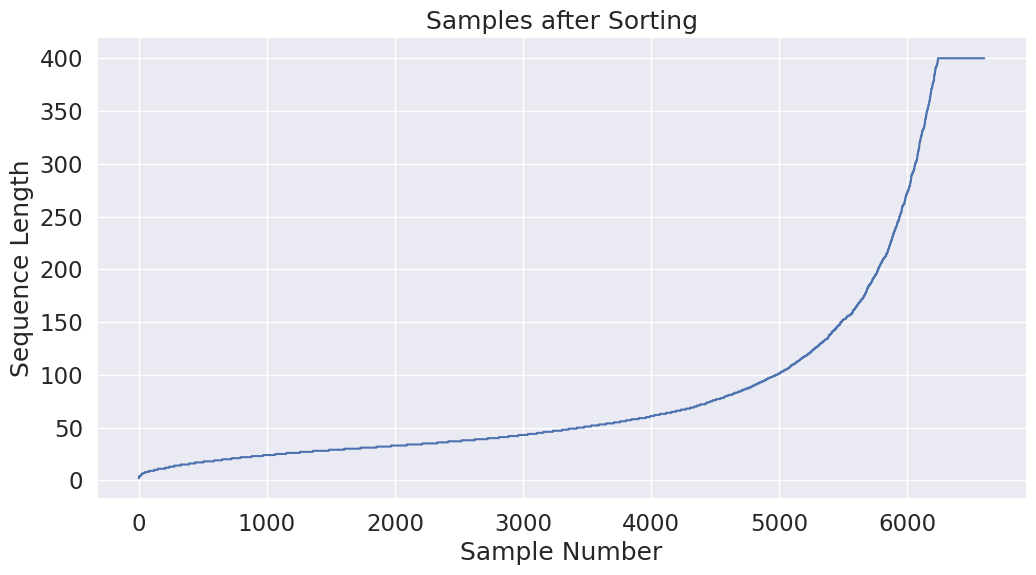

In [184]:


plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples after Sorting')

plt.show()

### Random Batch Selections

In [185]:
train_samples[0]

([101, 102], 1)

In [186]:
batch_size = 16

In [187]:
# List of batches that we'll construct.
batch_ordered_sentences = []
batch_ordered_labels = []

print('Creating training batches of size {:}'.format(batch_size))

# Loop over all of the input samples...
while len(train_samples) > 0:

    # Report progress.
    if ((len(batch_ordered_sentences) % 100) == 0):
        print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

    # `to_take` is our actual batch size. It will be `batch_size` until
    # we get to the last batch, which may be smaller.
    to_take = min(batch_size, len(train_samples))

    # Pick a random index in the list of remaining samples to start
    # our batch at.
    select = random.randint(0, len(train_samples) - to_take)

    # Select a contiguous batch of samples starting at `select`.
    batch = train_samples[select:(select + to_take)]

    # Each sample is a tuple--split them apart to create a separate list of
    # sequences and a list of labels for this batch.
    batch_ordered_sentences.append([s[0] for s in batch])
    batch_ordered_labels.append([s[1] for s in batch])

    # Remove these samples from the list.
    del train_samples[select:select + to_take]

print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))

Creating training batches of size 16
  Selected 0 batches.
  Selected 100 batches.
  Selected 200 batches.
  Selected 300 batches.
  Selected 400 batches.

  DONE - 413 batches.


In [188]:
print(batch_ordered_sentences[0])

[[101, 72065, 971, 28725, 12051, 970, 65240, 111240, 15002, 13228, 13104, 11128, 90738, 28777, 920, 108, 29005, 11587, 11281, 38039, 11090, 11233, 12051, 80501, 17511, 15215, 29740, 12235, 99092, 17460, 11248, 106, 106, 106, 29740, 12235, 99092, 978, 64437, 72614, 11128, 12051, 968, 12079, 92910, 22335, 12079, 97303, 960, 55971, 47719, 81323, 12711, 920, 80501, 17511, 15215, 109477, 27790, 41808, 14704, 26788, 15613, 950, 21790, 110153, 13104, 16755, 972, 53294, 61777, 938, 13104, 11128, 111240, 34070, 20513, 20430, 29740, 12235, 99092, 17460, 12711, 920, 946, 40061, 38833, 29740, 12235, 17511, 11128, 111240, 40433, 12051, 14374, 953, 11199, 38695, 12079, 28517, 53761, 119, 119, 119, 950, 80187, 18513, 955, 19910, 944, 36715, 974, 96105, 938, 22335, 113, 946, 26710, 14998, 114, 102], [101, 87664, 967, 68988, 42783, 12051, 938, 37376, 97507, 10595, 10336, 920, 60788, 978, 15002, 111240, 22335, 21790, 29904, 939, 54632, 44990, 20066, 12051, 80501, 17511, 15215, 948, 74501, 20979, 22335, 

In [189]:
batch_ordered_labels[0]

[2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 1, 1, 2]

### Padding

In [190]:
py_inputs = []
py_attn_masks = []
py_labels = []

# For each batch...
for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

    # New version of the batch, this time with padded sequences and now with
    # attention masks defined.
    batch_padded_inputs = []
    batch_attn_masks = []

    # First, find the longest sample in the batch.
    # Note that the sequences do currently include the special tokens!
    max_size = max([len(sen) for sen in batch_inputs])

    #print('Max size:', max_size)

    # For each input in this batch...
    for sen in batch_inputs:

        # How many pad tokens do we need to add?
        num_pads = max_size - len(sen)

        # Add `num_pads` padding tokens to the end of the sequence.
        padded_input = sen + [tokenizer.pad_token_id]*num_pads

        # Define the attention mask--it's just a `1` for every real token
        # and a `0` for every padding token.
        attn_mask = [1] * len(sen) + [0] * num_pads

        # Add the padded results to the batch.
        batch_padded_inputs.append(padded_input)
        batch_attn_masks.append(attn_mask)

    # Our batch has been padded, so we need to save this updated batch.
    # We also need the inputs to be PyTorch tensors, so we'll do that here.
    py_inputs.append(torch.tensor(batch_padded_inputs))
    py_attn_masks.append(torch.tensor(batch_attn_masks))
    py_labels.append(torch.tensor(batch_labels))


### Check the number of token reductions because of smart batching

In [191]:
# Get the new list of lengths after sorting.

padded_lengths = []

# For each batch...
for batch in py_inputs:

    # For each sample...
    for s in batch:

        # Record its length.
        padded_lengths.append(len(s))

# Sum up the lengths to the get the total number of tokens after smart batching.
smart_token_count = np.sum(padded_lengths)

# To get the total number of tokens in the dataset using fixed padding, it's
# as simple as the number of samples times our `max_len` parameter (that we
# would pad everything to).
fixed_token_count = len(train_sentences) * max_input_length

# Calculate the percentage reduction.
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count)

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))


Total tokens:
   Fixed Padding: 2,640,800
  Smart Batching: 614,384  (76.7% less)


## Load the model configuration from the transformers library using AutoConfig

In [192]:
# Load the Config object, with an output configured for classification.
config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name,
                                    num_labels=6)

print('Config type:', str(type(config)), '\n')


Config type: <class 'transformers.models.bert.configuration_bert.BertConfig'> 



In [193]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name,config = config)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual

In [194]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

## Load the model from the transformers library using AutoModel

In [195]:
# Load the pre-trained model for classification, passing in the `config` from
# above.
bert = AutoModel.from_pretrained(
    pretrained_model_name_or_path=model_name,
    config=config)

print('\nModel type:', str(type(bert)))


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Model type: <class 'transformers.models.bert.modeling_bert.BertModel'>


In [196]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## Loading Optimizer

In [197]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # This is the value Michael used.
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Loading lr scheduler

In [198]:
# Number of training epochs. I chose to train for 1 simply because the training
# time is long. More epochs may improve the model's accuracy.
epochs = 5

# Total number of training steps is [number of batches] x [number of epochs].
# Note that it's the number of *batches*, not *samples*!
total_steps = len(py_inputs) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Training Loop

In [199]:
# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = {
    'epoch':[],
    'train_loss':[],
    'Training Time':[],
    'val_loss':[],
    'Validation Time':[],
    'train_acc':[],
    'val_acc':[]
}

# Update every `update_interval` batches.
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    predictions = []
    true_labels = []

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))

    # At the start of each epoch (except for the first) we need to re-randomize
    # our training data.
    if epoch_i > 0:
        # Use our `make_smart_batches` function (from 6.1.) to re-shuffle the
        # dataset into new batches.
        (py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size,tokenizer,max_input_length)

    print('Training on {:,} batches...'.format(len(py_inputs)))

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step in range(0, len(py_inputs)):

        # Progress update every, e.g., 100 batches.
        if step % update_interval == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Calculate the time remaining based on our progress.
            steps_per_sec = (time.time() - t0) / step
            remaining_sec = steps_per_sec * (len(py_inputs) - step)
            remaining = format_time(remaining_sec)

            # Report progress.
            print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

        # Copy the current training batch to the GPU using the `to` method.
        b_input_ids = py_inputs[step].to(device)
        b_input_mask = py_attn_masks[step].to(device)
        b_labels = py_labels[step].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The call returns the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        loss = output.loss
        logits = output.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(py_inputs)

    training_accuracy = check_accuracy(predictions,true_labels)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training Accuracy: {0:.2f}".format(training_accuracy))
    print("  Training epoch took: {:}".format(training_time))

    (py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels, batch_size ,tokenizer,max_input_length)
    val_loss,val_accuracy,validation_time = eval_model(model,py_inputs, py_attn_masks, py_labels)
    # Record all statistics from this epoch.

    print("")
    print("  Average validation loss: {0:.2f}".format(val_loss))
    print("  Validation Accuracy: {0:.2f}".format(val_accuracy))
    print("  Validation epoch took: {:}".format(validation_time))


    training_stats['epoch'].append(epoch_i + 1)
    training_stats['train_loss'].append(avg_train_loss)
    training_stats['Training Time'].append(training_time)
    training_stats['val_loss'].append(val_loss)
    training_stats['Validation Time'].append(validation_time)
    training_stats['train_acc'].append(training_accuracy)
    training_stats['val_acc'].append(val_accuracy)

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training on 413 batches...
  Batch      40  of      413.    Elapsed: 0:00:14.  Remaining: 0:02:07
  Batch      80  of      413.    Elapsed: 0:00:25.  Remaining: 0:01:45
  Batch     120  of      413.    Elapsed: 0:00:38.  Remaining: 0:01:32
  Batch     160  of      413.    Elapsed: 0:00:51.  Remaining: 0:01:21
  Batch     200  of      413.    Elapsed: 0:01:03.  Remaining: 0:01:07
  Batch     240  of      413.    Elapsed: 0:01:14.  Remaining: 0:00:54
  Batch     280  of      413.    Elapsed: 0:01:24.  Remaining: 0:00:40
  Batch     320  of      413.    Elapsed: 0:01:37.  Remaining: 0:00:28
  Batch     360  of      413.    Elapsed: 0:01:48.  Remaining: 0:00:16
  Batch     400  of      413.    Elapsed: 0:02:00.  Remaining: 0:00:04

  Average training loss: 0.62
  Training Accuracy: 0.77
  Training epoch took: 0:02:06
Creating Smart Batches from 2,201 examples with batch size 16...

Tokenizing 2,201 samples...
  Tokenized 0 samples.
  Tokenized 200 samples.
  

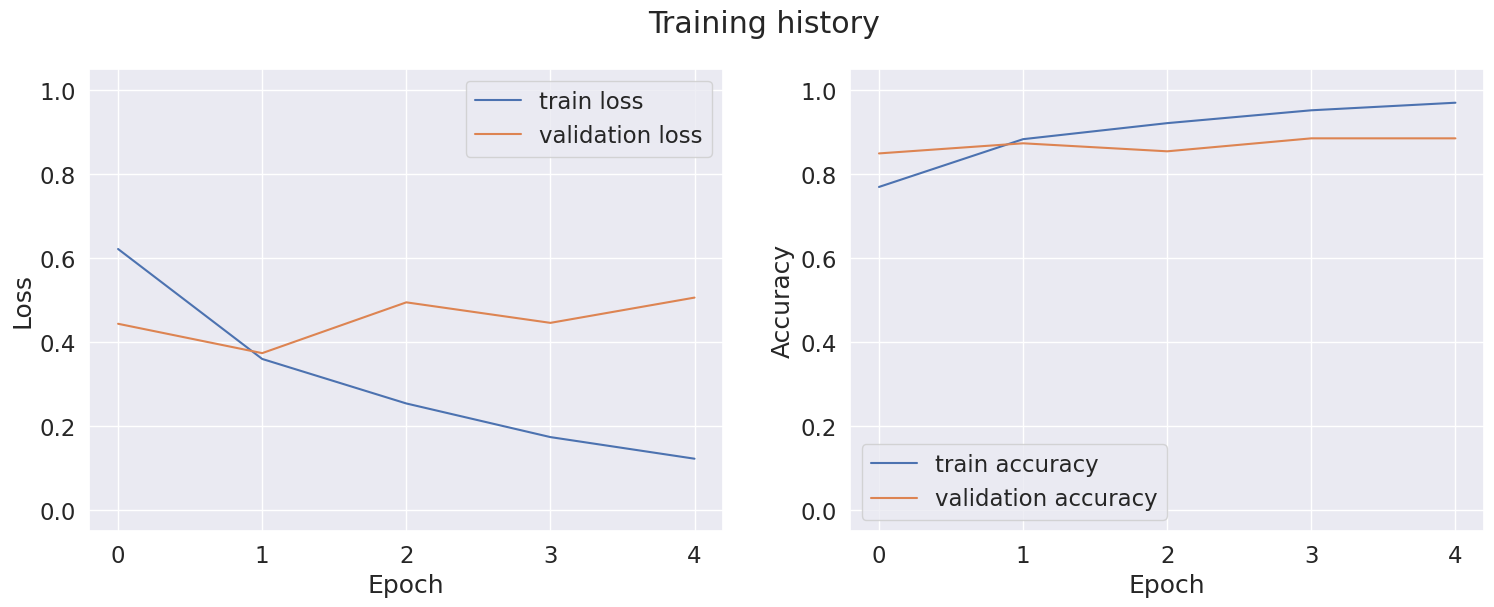

In [200]:
plot_training_history(training_stats)

## Evaluating Performance Over Training Set

In [201]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)


Creating Smart Batches from 6,602 examples with batch size 16...

Tokenizing 6,602 samples...
  Tokenized 0 samples.
  Tokenized 700 samples.
  Tokenized 1,400 samples.
  Tokenized 2,100 samples.
  Tokenized 2,800 samples.
  Tokenized 3,500 samples.
  Tokenized 4,200 samples.
  Tokenized 4,900 samples.
  Tokenized 5,600 samples.
  Tokenized 6,300 samples.
DONE.
     6,602 samples

     6,602 samples after sorting

Creating batches of size 16...

  DONE - Selected 413 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 413 test batches...
  Batch      40  of      413.    Elapsed: 0:00:04.  Remaining: 0:00:35
  Batch      80  of      413.    Elapsed: 0:00:07.  Remaining: 0:00:31
  Batch     120  of      413.    Elapsed: 0:00:11.  Remaining: 0:00:27
  Batch     160  of      413.    Elapsed: 0:00:15.  Remaining: 0:00:24
  Batch     200  of      413.    Elapsed: 0:00:17.  Remaining: 0:00:18
  Batch     240  of      413.    Elapsed: 0:00:21.  Remaining: 0:00:15

In [202]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    positive       0.99      0.97      0.98      2647
    negative       0.98      0.99      0.98       610
     neutral       0.97      0.99      0.98      3345

    accuracy                           0.98      6602
   macro avg       0.98      0.98      0.98      6602
weighted avg       0.98      0.98      0.98      6602



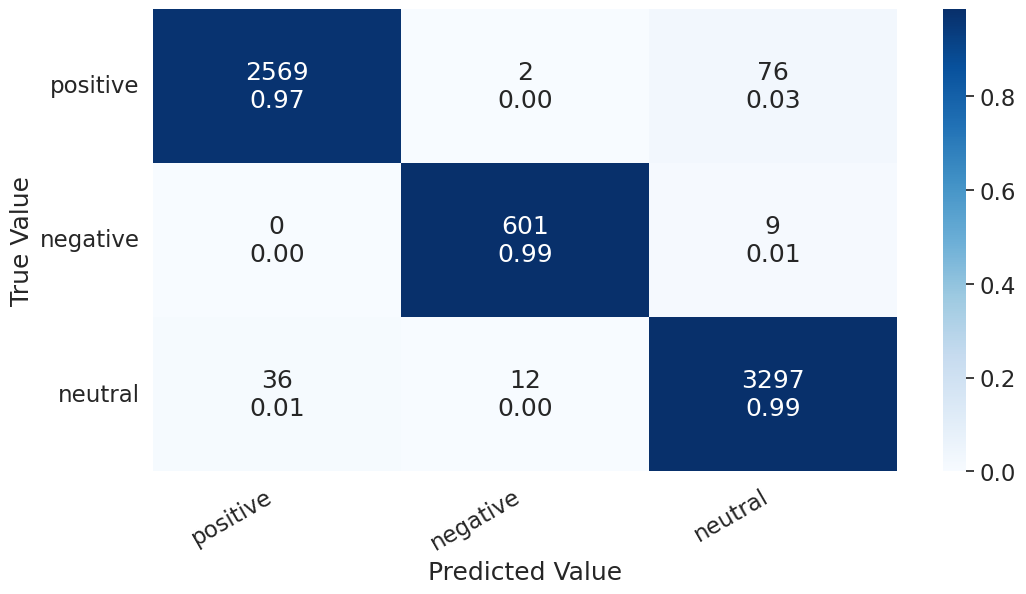

In [203]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Evaluating Performance Over Validation Set

In [204]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

Creating Smart Batches from 2,201 examples with batch size 16...

Tokenizing 2,201 samples...
  Tokenized 0 samples.
  Tokenized 200 samples.
  Tokenized 400 samples.
  Tokenized 600 samples.
  Tokenized 800 samples.
  Tokenized 1,000 samples.
  Tokenized 1,200 samples.
  Tokenized 1,400 samples.
  Tokenized 1,600 samples.
  Tokenized 1,800 samples.
  Tokenized 2,000 samples.
  Tokenized 2,200 samples.
DONE.
     2,201 samples

     2,201 samples after sorting

Creating batches of size 16...

  DONE - Selected 138 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 138 test batches...
  Batch      10  of      138.    Elapsed: 0:00:01.  Remaining: 0:00:12
  Batch      20  of      138.    Elapsed: 0:00:02.  Remaining: 0:00:11
  Batch      30  of      138.    Elapsed: 0:00:03.  Remaining: 0:00:09
  Batch      40  of      138.    Elapsed: 0:00:04.  Remaining: 0:00:10
  Batch      50  of      138.    Elapsed: 0:00:05.  Remaining: 0:00:09
  Batch      60  of   

In [205]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    positive       0.86      0.89      0.88       896
    negative       0.85      0.84      0.84       181
     neutral       0.91      0.89      0.90      1124

    accuracy                           0.89      2201
   macro avg       0.87      0.87      0.87      2201
weighted avg       0.89      0.89      0.89      2201



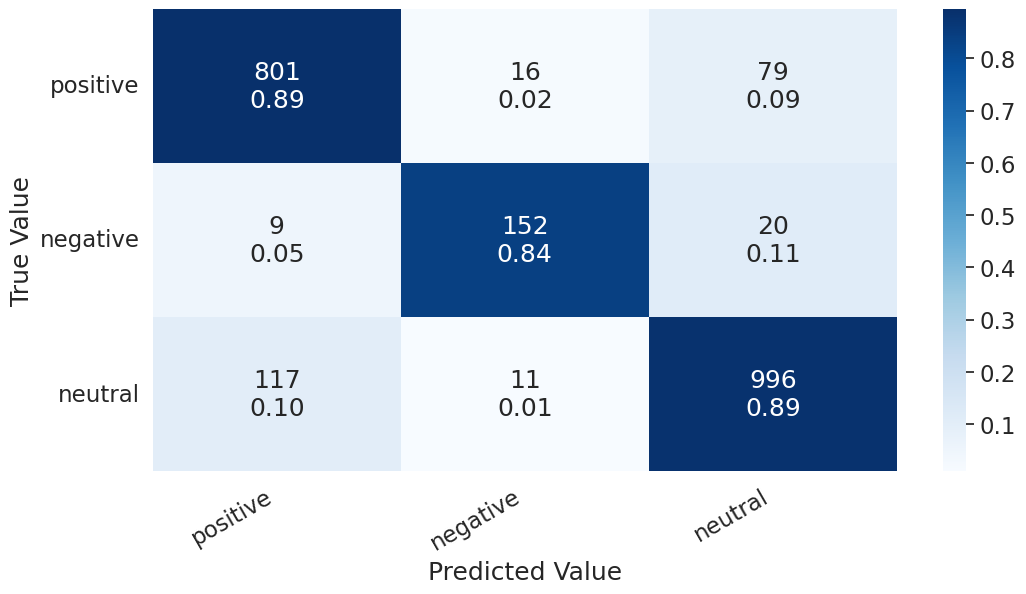

In [206]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Making Predictions on Test Set

In [207]:
# test_df_path = join(dataset_dir,'tamil_offensive_full_test.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ariful/test_data.csv')

In [208]:
test_df

,PID,text,labels
0,1499,ভোজন রসিক জন্য ভালো .. (ওয়াই),positive
1,5287,"আমি তাদের খাদ্য মতো, তারা তাদের গ্রাহক খুব সহা...",positive
2,7546,"যখন Tempe, বাজারে জায়গা একত্র করা হচ্ছে ... আ...",negative
3,3232,"জট্টিল Nachos, বিশেষ করে B.B.Q Nachos। আমি এটা...",positive
4,715,এটা শুধু অসাধারন জায়গা। খাদ্য স্বাদ এবং গুণমা...,positive
...,...,...,...
2196,5323,পরিবার ঘুরাঘুরি এর জন্য সবচেয়ে ভাল জায়গা। আর...,positive
2197,4975,খাদ্যে তাই সুস্বাদু হয়,positive
2198,8492,আমি আগে তাই আমি অনুমান আমি এটা তুলনা নেই থাই খ...,negative
2199,7821,:( আমি সত্যিই পছন্দ করেন এই জাগা করতে চেয়েছিল...,negative


## Loading `test_sentences`

In [209]:
test_sentences = test_df['text'].values
test_labels = test_df['labels'].values
test_ids = test_df.index.values

In [210]:
test_ids

array([   0,    1,    2, ..., 2198, 2199, 2200])

In [211]:
(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, 16,tokenizer,max_input_length)

Creating Smart Batches from 2,201 examples with batch size 16...

Tokenizing 2,201 samples...
  Tokenized 0 samples.
  Tokenized 200 samples.
  Tokenized 400 samples.
  Tokenized 600 samples.
  Tokenized 800 samples.
  Tokenized 1,000 samples.
  Tokenized 1,200 samples.
  Tokenized 1,400 samples.
  Tokenized 1,600 samples.
  Tokenized 1,800 samples.
  Tokenized 2,000 samples.
  Tokenized 2,200 samples.
DONE.
     2,201 samples

     2,201 samples after sorting

Creating batches of size 16...

  DONE - Selected 138 batches.

Padding out sequences within each batch...
  DONE.


In [212]:
y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


Predicting labels for 138 test batches...
  Batch      10  of      138.    Elapsed: 0:00:01.  Remaining: 0:00:10
  Batch      20  of      138.    Elapsed: 0:00:02.  Remaining: 0:00:09
  Batch      30  of      138.    Elapsed: 0:00:02.  Remaining: 0:00:09
  Batch      40  of      138.    Elapsed: 0:00:03.  Remaining: 0:00:07
  Batch      50  of      138.    Elapsed: 0:00:04.  Remaining: 0:00:07
  Batch      60  of      138.    Elapsed: 0:00:05.  Remaining: 0:00:06
  Batch      70  of      138.    Elapsed: 0:00:06.  Remaining: 0:00:05
  Batch      80  of      138.    Elapsed: 0:00:07.  Remaining: 0:00:05
  Batch      90  of      138.    Elapsed: 0:00:07.  Remaining: 0:00:04
  Batch     100  of      138.    Elapsed: 0:00:09.  Remaining: 0:00:03
  Batch     110  of      138.    Elapsed: 0:00:09.  Remaining: 0:00:02
  Batch     120  of      138.    Elapsed: 0:00:10.  Remaining: 0:00:02
  Batch     130  of      138.    Elapsed: 0:00:11.  Remaining: 0:00:01


In [213]:

test_sentences

array(['ভোজন রসিক জন্য ভালো .. (ওয়াই)',
       'আমি তাদের খাদ্য মতো, তারা তাদের গ্রাহক খুব সহায়ক।',
       "যখন Tempe, বাজারে জায়গা একত্র করা হচ্ছে ... আমি যদিও ওয়াও একটি চট্পটে জায়গা যেখানে কলেজ বাচ্চাদের এবং পাড়া ফিরে প্রাপ্তবয়স্কদের একসাথে পেতে এবং নিজেদের ভোগ করতে পারে। ক্যাডিল্যাক খামারবাড়ি নির্মিত হচ্ছে ছিল ... এবং প্রতারণা গরম আপনি একটি সময় খাবার এগিয়ে কিনতে করতে যথেষ্ট ছিল। রিভিউ পড়ুন কিন্তু চিন্তার ... তারা হেই দেয় কি এটা চেষ্টা। আর এখন আমি দেখতে কেন এটিকে দুটি স্টার আছে ... অন্যান্য yelpers শোনার উচিত -_-... গিয়েছিলাম গুড OLE নেই 'Rada, ভেবেছিলাম এটা চমৎকার হবে দিন বাহিরে উপভোগ করতে। প্রায় misters এর প্রশস্ত পরিমাণ দ্বারা নিমজ্জিত। স্ব বলে মনে করা ... হুম ভাল অন্তত খাদ্য ভাল হওয়া উচিত। স্লাইডার খাবার অর্ডার দেওয়া ... তারা হয়তো মাংস উপর দুর্লভ ছিল, কিন্তু স্লাইডার পাটিয়ে রূপা ডলার, সুস্বাদু কিন্তু ছোট আকার ছিল। হ্যাঁ সেবা ধীর ছিল; আমার কাচ দ্রুত প্রকৃত ওয়েটার চেয়ে misters দ্বারা পুনরায় ভরাট পেয়ে ছিল। এটা তোলে পরিষেবা এবং সামগ্রিক অভিজ্ঞতা (লাঞ্চের জন্য যে

In [214]:
(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, 16,tokenizer,max_input_length)
y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

Creating Smart Batches from 2,201 examples with batch size 16...

Tokenizing 2,201 samples...
  Tokenized 0 samples.
  Tokenized 200 samples.
  Tokenized 400 samples.
  Tokenized 600 samples.
  Tokenized 800 samples.
  Tokenized 1,000 samples.
  Tokenized 1,200 samples.
  Tokenized 1,400 samples.
  Tokenized 1,600 samples.
  Tokenized 1,800 samples.
  Tokenized 2,000 samples.
  Tokenized 2,200 samples.
DONE.
     2,201 samples

     2,201 samples after sorting

Creating batches of size 16...

  DONE - Selected 138 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 138 test batches...
  Batch      10  of      138.    Elapsed: 0:00:01.  Remaining: 0:00:08
  Batch      20  of      138.    Elapsed: 0:00:01.  Remaining: 0:00:07
  Batch      30  of      138.    Elapsed: 0:00:02.  Remaining: 0:00:06
  Batch      40  of      138.    Elapsed: 0:00:03.  Remaining: 0:00:08
  Batch      50  of      138.    Elapsed: 0:00:04.  Remaining: 0:00:08
  Batch      60  of   

## Evaluating accuracy over test set

In [215]:
y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


Predicting labels for 138 test batches...
  Batch      10  of      138.    Elapsed: 0:00:01.  Remaining: 0:00:08
  Batch      20  of      138.    Elapsed: 0:00:01.  Remaining: 0:00:07
  Batch      30  of      138.    Elapsed: 0:00:02.  Remaining: 0:00:06
  Batch      40  of      138.    Elapsed: 0:00:03.  Remaining: 0:00:08
  Batch      50  of      138.    Elapsed: 0:00:05.  Remaining: 0:00:08
  Batch      60  of      138.    Elapsed: 0:00:06.  Remaining: 0:00:07
  Batch      70  of      138.    Elapsed: 0:00:07.  Remaining: 0:00:06
  Batch      80  of      138.    Elapsed: 0:00:07.  Remaining: 0:00:05
  Batch      90  of      138.    Elapsed: 0:00:08.  Remaining: 0:00:04
  Batch     100  of      138.    Elapsed: 0:00:09.  Remaining: 0:00:03
  Batch     110  of      138.    Elapsed: 0:00:09.  Remaining: 0:00:02
  Batch     120  of      138.    Elapsed: 0:00:10.  Remaining: 0:00:01
  Batch     130  of      138.    Elapsed: 0:00:11.  Remaining: 0:00:01


In [216]:
print(y_preds)

[2 0 0 ... 0 0 0]


In [217]:
print(y_ids)

[ 373  429  463 ... 2042 2050 2175]


In [218]:
le.inverse_transform(y_preds)

array(['positive', 'negative', 'negative', ..., 'negative', 'negative',
       'negative'], dtype=object)

<Axes: xlabel='count'>

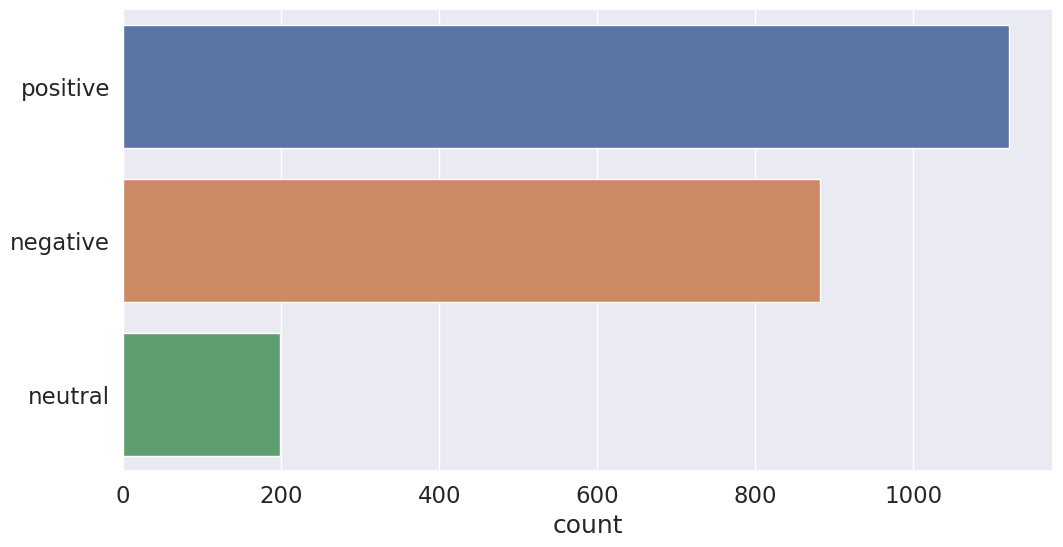

In [219]:
sns.countplot(y =le.inverse_transform(y_preds))

In [220]:
len(y_ids)

2201

In [221]:
y_pred=le.inverse_transform(y_preds)
y_pred

array(['positive', 'negative', 'negative', ..., 'negative', 'negative',
       'negative'], dtype=object)

In [222]:
len(y_pred)

2201

In [223]:
test_labels

array(['positive', 'positive', 'negative', ..., 'negative', 'negative',
       'positive'], dtype=object)

In [224]:
len(y_preds)

2201

## Creating Submission DataFrame

In [225]:


df_new = pd.DataFrame({
    'id':y_ids,
    'plabels':le.inverse_transform(y_preds)
})

In [226]:

test_df['id'] = test_df.index

In [227]:
df_new

,id,plabels
0,373,positive
1,429,negative
2,463,negative
3,491,negative
4,544,neutral
...,...,...
2196,2014,negative
2197,2035,negative
2198,2042,negative
2199,2050,negative


In [228]:
test_df

,PID,text,labels,id
0,1499,ভোজন রসিক জন্য ভালো .. (ওয়াই),positive,0
1,5287,"আমি তাদের খাদ্য মতো, তারা তাদের গ্রাহক খুব সহা...",positive,1
2,7546,"যখন Tempe, বাজারে জায়গা একত্র করা হচ্ছে ... আ...",negative,2
3,3232,"জট্টিল Nachos, বিশেষ করে B.B.Q Nachos। আমি এটা...",positive,3
4,715,এটা শুধু অসাধারন জায়গা। খাদ্য স্বাদ এবং গুণমা...,positive,4
...,...,...,...,...
2196,5323,পরিবার ঘুরাঘুরি এর জন্য সবচেয়ে ভাল জায়গা। আর...,positive,2196
2197,4975,খাদ্যে তাই সুস্বাদু হয়,positive,2197
2198,8492,আমি আগে তাই আমি অনুমান আমি এটা তুলনা নেই থাই খ...,negative,2198
2199,7821,:( আমি সত্যিই পছন্দ করেন এই জাগা করতে চেয়েছিল...,negative,2199


In [229]:
df_f = pd.merge(test_df,df_new,on = 'id')
df_f

,PID,text,labels,id,plabels
0,1499,ভোজন রসিক জন্য ভালো .. (ওয়াই),positive,0,positive
1,5287,"আমি তাদের খাদ্য মতো, তারা তাদের গ্রাহক খুব সহা...",positive,1,negative
2,7546,"যখন Tempe, বাজারে জায়গা একত্র করা হচ্ছে ... আ...",negative,2,negative
3,3232,"জট্টিল Nachos, বিশেষ করে B.B.Q Nachos। আমি এটা...",positive,3,positive
4,715,এটা শুধু অসাধারন জায়গা। খাদ্য স্বাদ এবং গুণমা...,positive,4,positive
...,...,...,...,...,...
2196,5323,পরিবার ঘুরাঘুরি এর জন্য সবচেয়ে ভাল জায়গা। আর...,positive,2196,positive
2197,4975,খাদ্যে তাই সুস্বাদু হয়,positive,2197,positive
2198,8492,আমি আগে তাই আমি অনুমান আমি এটা তুলনা নেই থাই খ...,negative,2198,negative
2199,7821,:( আমি সত্যিই পছন্দ করেন এই জাগা করতে চেয়েছিল...,negative,2199,negative


In [230]:
df_f = df_f[['PID','plabels']]
final_label=df_f['plabels']

In [231]:
final_label

0       positive
1       negative
2       negative
3       positive
4       positive
          ...   
2196    positive
2197    positive
2198    negative
2199    negative
2200    positive
Name: plabels, Length: 2201, dtype: object

In [232]:
print(classification_report(test_labels, final_label, target_names=class_names, digits=4))

              precision    recall  f1-score   support

    positive     0.8753    0.8987    0.8868       859
    negative     0.8384    0.8783    0.8579       189
     neutral     0.9206    0.8951    0.9077      1153

    accuracy                         0.8950      2201
   macro avg     0.8781    0.8907    0.8841      2201
weighted avg     0.8959    0.8950    0.8953      2201



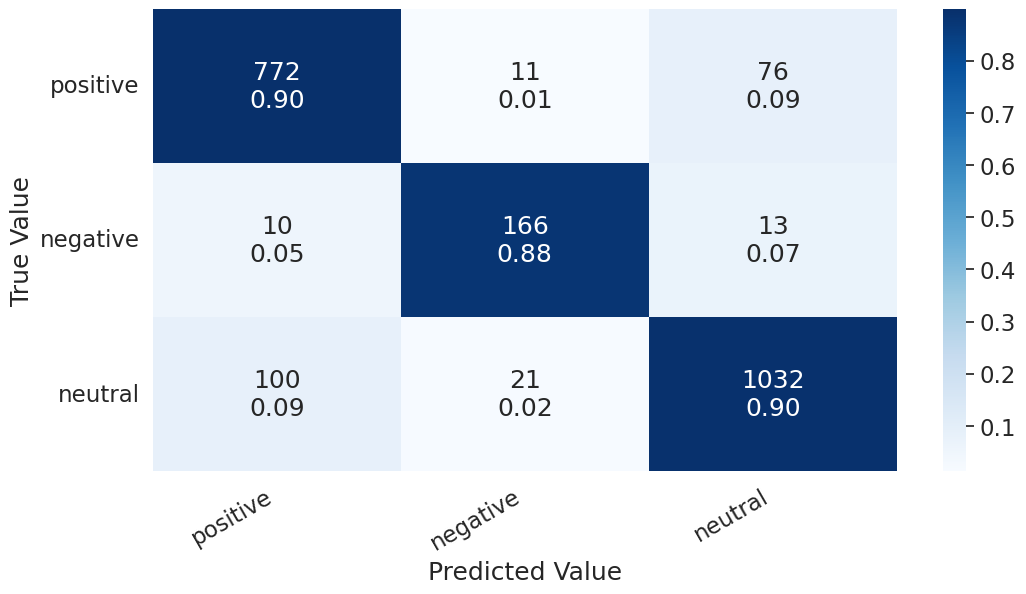

In [233]:
cm = confusion_matrix(test_labels, final_label)
show_confusion_matrix(cm, class_names)